In [44]:
import ibm_db
import ibm_db_dbi
import pandas as pd
import numpy as np
import pickle
from pyhive import hive
from TCLIService.ttypes import TOperationState
from datetime import timedelta
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import glob 
#conn = ibm_db.connect("DATABASE=D2CPROD;HOSTNAME=MARSPROD;PORT=50050;PROTOCOL=TCPIP;UID=YH03143;PWD=Jan2018$;", "", "")
#pconn = ibm_db_dbi.Connection(conn)
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
import scipy.stats as stats
from pylab import rcParams
from sklearn.metrics import mean_squared_error, r2_score
import datetime as datetime

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import os
path = "F:\\OneDrive - WHISK SOFTWARE PVT. LTD\\Sequence by Segment\\"
os.chdir(path)

In [129]:
def get_user_data(date1,date2):
    sql = """SELECT WEB_PROD_ID, USR_ID, ORIG_ORD_DT, SUM(LST_COST_EXTD_AMT) SALES 
        FROM MFACT.SALES_FACT_T 
        WHERE ORIG_ORD_DT BETWEEN DATE('temp_date1') AND DATE('temp_date2')   
        AND sell_zl_loc_nbr IN (129, 139)
        AND TXN_TYP_CD IN ('S','R','E')
        AND USR_ID IS NOT NULL
        AND SELL_OPER_DIVN_NBR = 12
        GROUP BY WEB_PROD_ID, USR_ID, ORIG_ORD_DT
        """
    sql = sql.replace("temp_date1",date1).replace("temp_date2",date2)
    user_data = pd.read_sql(sql, pconn)
    print user_data.shape
    return user_data

def create_sum_data(date):
    sql = """SELECT WEB_PROD_ID, USR_ID, sum(LST_COST_AMT) sales 
    FROM MFACT.SALES_FACT_T 
    WHERE ORIG_ORD_DT = 'temp_date'   
    AND sell_zl_loc_nbr IN (129, 139)
    AND TXN_TYP_CD IN ('S','R','E')
    AND USR_ID IS NOT NULL
    AND SELL_OPER_DIVN_NBR = 12
    GROUP BY WEB_PROD_ID, USR_ID"""
    sql = sql.replace("temp_date",date)
    user_data = pd.read_sql(sql, pconn)
    print user_data.shape
    return user_data

def get_DOB_data():
    sql = """WITH SA AS (
                select * from (
                select S.WEB_PROD_ID, sum(S.LST_COST_EXTD_AMT) sales, sum(item_unit_qty) qty, S.USR_ID, S.ORIG_ORD_DT
                from MFACT.SALES_FACT_T S
                where S.SELL_OPER_DIVN_NBR = 12
                AND S.sell_zl_loc_nbr IN (129, 139)
                AND S.TXN_TYP_CD IN ('S','R','E')
                AND S.USR_ID IS NOT NULL
                AND ORIG_ORD_DT  BETWEEN DATE('2018-01-21') AND DATE('2018-02-01')
                GROUP BY S.WEB_PROD_ID, S.USR_ID, S.ORIG_ORD_DT
                )a where sales>0
                ),
                CUST AS (
                select * from (
                  SELECT D.DOB_DT, A.SRC_SYS_KEY,
                  CASE
                    WHEN D.DOB_DT BETWEEN '1883-01-01'AND '1900-12-31'THEN 1
                    WHEN D.DOB_DT BETWEEN '1901-01-01'AND '1924-12-31'THEN 2
                    WHEN D.DOB_DT BETWEEN '1925-01-01'AND '1942-12-31'THEN 3
                    WHEN D.DOB_DT BETWEEN '1943-01-01'AND '1962-12-31'THEN 4
                    WHEN D.DOB_DT BETWEEN '1963-01-01'AND '1982-12-31'THEN 5
                    WHEN D.DOB_DT BETWEEN '1983-01-01'AND '1998-12-31'THEN 6
                    WHEN D.DOB_DT BETWEEN '2016-01-01'AND '2019-12-31'THEN 7
                  END AS SEGMENT,
                  SUM(C.R_SCR_NBR)R_Score,SUM(F_SCR_NBR)F_Score,SUM(M_SCR_NBR)M_Score,SUM(RFM_SCR_NBR) RFM_SCORE,SUM(RFM_SEG_IND) RFM_SEG
                  FROM MCUST.ACCT_MSTR A,MCUST.ACCT_INDIV_HHLD_RLTN I,MCUST.INDIV_MSTR_DMGRPH D, MCUST.INDIV_MSTR C
                     WHERE A.ACCT_TYP_CD = 'SPF'
                       AND A.ACCT_ID = I.ACCT_ID
                       AND I.INDIV_ID = D.INDIV_ID
                       AND I.INDIV_ID = C.INDIV_ID
                       AND D.DOB_DT IS NOT NULL
                       AND I.CURR_IND = 'Y'
                       GROUP BY D.DOB_DT, A.SRC_SYS_KEY,
                       CASE
                         WHEN D.DOB_DT BETWEEN '1883-01-01'AND '1900-12-31'THEN 1
                         WHEN D.DOB_DT BETWEEN '1901-01-01'AND '1924-12-31'THEN 2
                         WHEN D.DOB_DT BETWEEN '1925-01-01'AND '1942-12-31'THEN 3
                         WHEN D.DOB_DT BETWEEN '1943-01-01'AND '1962-12-31'THEN 4
                         WHEN D.DOB_DT BETWEEN '1963-01-01'AND '1982-12-31'THEN 5
                         WHEN D.DOB_DT BETWEEN '1983-01-01'AND '1998-12-31'THEN 6
                         WHEN D.DOB_DT BETWEEN '2016-01-01'AND '2019-12-31'THEN 7
                       END
                       )
                    )
                      SELECT SA.ORIG_ORD_DT,C.SRC_SYS_KEY,SA.WEB_PROD_ID,C.SEGMENT,SA.SALES,SA.QTY,C.R_SCORE,C.F_SCORE,C.M_SCORE,
                                      C.RFM_SCORE,C.RFM_SEG
                      FROM SA, CUST C
                      WHERE C.SRC_SYS_KEY = SA.USR_ID
  """

    DOB_Data = pd.read_sql(sql, pconn)
    DOB_Data.to_csv("USER_DOB_DATA.csv",index=False)
    print DOB_Data.shape
    print "DOB data saved!"

def get_user_segment_data(date):
    user_data_sql = """WITH SA AS (
                                select * from (
                                    select S.WEB_PROD_ID, sum(S.LST_COST_EXTD_AMT) SALES, S.USR_ID, S.ORIG_ORD_DT
                                    from MFACT.SALES_FACT_T S
                                    where S.SELL_OPER_DIVN_NBR = 12 
                                    AND S.sell_zl_loc_nbr IN (129, 139)
                                    AND S.TXN_TYP_CD IN ('S','R','E')
                                    AND S.USR_ID IS NOT NULL
                                    AND S.ORIG_ORD_DT = 'temp_date'
                                    GROUP BY S.WEB_PROD_ID, S.USR_ID, S.ORIG_ORD_DT	
                                    )a where SALES>0
                                )
                SELECT SA.WEB_PROD_ID, SA.sales, SA.USR_ID, SA.ORIG_ORD_DT, D.DOB_DT,
                CASE 
                    WHEN D.DOB_DT BETWEEN '1883-01-01' AND '1900-12-31' THEN 1
                    WHEN D.DOB_DT BETWEEN '1901-01-01' AND '1924-12-31' THEN 2
                    WHEN D.DOB_DT BETWEEN '1925-01-01' AND '1942-12-31' THEN 3
                    WHEN D.DOB_DT BETWEEN '1943-01-01' AND '1962-12-31' THEN 4
                    WHEN D.DOB_DT BETWEEN '1963-01-01' AND '1982-12-31' THEN 5
                    WHEN D.DOB_DT BETWEEN '1983-01-01' AND '1998-12-31' THEN 6
                    WHEN D.DOB_DT BETWEEN '1999-01-01' AND '2015-12-31' THEN 7
                    WHEN D.DOB_DT BETWEEN '2016-01-01' AND '2020-12-31' THEN 8
                END AS SEGMENT
                FROM MCUST.ACCT_MSTR A, MCUST.ACCT_INDIV_HHLD_RLTN I,MCUST.INDIV_MSTR_DMGRPH D, SA
                WHERE A.ACCT_TYP_CD = 'SPF'
                AND A.ACCT_ID = I.ACCT_ID
                AND I.INDIV_ID = D.INDIV_ID
                AND A.SRC_SYS_KEY = SA.USR_ID
                AND I.CURR_IND = 'Y'
                AND D.DOB_DT IS NOT NULL"""
    user_data_sql = user_data_sql.replace("temp_date",date)
    user_data = pd.read_sql(user_data_sql, pconn)
    return user_data

def get_rdpp_dump(rdpp_date):
    rdpp_fileName = glob.glob("/data/sequencing/dumps/"+rdpp_date+"*")[0]
    data = pd.read_csv(rdpp_fileName,compression='gzip',header=None)
    data.drop([1,4,5,6,7,8,9],axis=1,inplace=True)
    data.columns = ["PRODUCT_ID","METRIC_NAME","METRIC_VALUE"]
    pivot = data.pivot(index="PRODUCT_ID",columns="METRIC_NAME",values="METRIC_VALUE").reset_index(None)
    pivot.drop(['NEWNESS','SALES_DOLLARS_REGION_1','SALES_DOLLARS_REGION_2','SALES_DOLLARS_REGION_3','SALES_DOLLARS_REGION_4',
                'SALES_DOLLARS_REGION_5'],1,inplace=True)

    for col in pivot.columns:
            if col not in ['CLEARANCE_PRICE_TYPE','LPOS_PRICE_TYPE','ON_PROMOTION','REBATES','SALE_PRICE_TYPE']:
                pivot[col]=pd.to_numeric(pivot[col], errors='coerce')
                
    pivot = pivot.dropna()
    pivot = encoder(pivot,'CLEARANCE_PRICE_TYPE')
    pivot = encoder(pivot,'LPOS_PRICE_TYPE')
    pivot = encoder(pivot,'ON_PROMOTION')
    pivot = encoder(pivot,'REBATES')
    pivot = encoder(pivot,'SALE_PRICE_TYPE')
    #pivot = encoder(pivot,'HOME_CAT_ID')
    return pivot


def get_prod_views(rdpp_date):
    sql_views = """SELECT PRODUCT_ID, COUNT(distinct SESSION_ID) as view_count FROM ltrfc.cm_product_view WHERE dt='rdpp_date' 
                                GROUP BY PRODUCT_ID"""
    sql_views = sql_views.replace('rdpp_date',rdpp_date)
    cursor = hive.connect('11.120.105.80').cursor()
    cursor.execute(sql_views, async=True)

    status = cursor.poll().operationState
    while status in (TOperationState.INITIALIZED_STATE, TOperationState.RUNNING_STATE):
        logs = cursor.fetch_logs()
        for message in logs:
            print message
        status = cursor.poll().operationState

    prodView_data = pd.DataFrame(cursor.fetchall())
    cursor.close()
    prodView_data.columns = ['PRODUCT_ID','PRODUCT_VIEWS']
    prodView_data['PRODUCT_ID'] = prodView_data['PRODUCT_ID'].apply(lambda x: int(x.replace("-","").replace(",","")) if str(x).isdigit() else None)
    prodView_data.dropna(inplace=True)
    return prodView_data

def get_views_data(date):
    sql_views = """select p.product_id, r.registration_id, count(p.product_id) views from ltrfc.cm_registration r, 
    ltrfc.cm_product_view p where r.session_id=p.session_id and p.event_date = 'temp_date' group by p.product_id, 
    r.registration_id"""

    sql_views = sql_views.replace("temp_date",date)
    cursor = hive.connect('11.120.105.80').cursor()
    cursor.execute(sql_views, async=True)
    status = cursor.poll().operationState
    while status in (TOperationState.INITIALIZED_STATE, TOperationState.RUNNING_STATE):
        logs = cursor.fetch_logs()
        #for message in logs:
            #print message
        status = cursor.poll().operationState

    view_data = pd.DataFrame(cursor.fetchall())
    view_data.columns = ['PRODUCT_ID','EMAIL','VIEWS']
    view_data_group = view_data[['PRODUCT_ID','VIEWS']].groupby(['PRODUCT_ID']).sum().reset_index(None)
    return view_data_group

def encoder(data,colName):
    le = preprocessing.LabelEncoder()
    data[colName] = le.fit_transform(data[colName])
    return data

def get_rdpp_metric(date,cat):
    sql = "select *  from MSYND.RDPP_RAW_METRICS WHERE  METRIC_RUN_DT = 'temp_date'"
    sql = sql.replace("temp_date",date)
    df = pd.read_sql(sql, pconn)
    print "Metric Data loaded"
    df.drop(['METRIC_RUN_DT','UPD_TS','UPD_USR_ID','CRTE_TS','CRTE_USR_ID','PRG_NM'],1,inplace=True)
    pivot_df = df.pivot(index="PRODUCT_ID",columns="METRIC_NAME",values="METRIC_VALUE").reset_index(None)
    pivot_df = pivot_df.drop(['SALES_DOLLARS_REGION_1','SALES_DOLLARS_REGION_2','SALES_DOLLARS_REGION_3',
                       'SALES_DOLLARS_REGION_4','SALES_DOLLARS_REGION_5'],1)
    pivot_df.drop("NEWNESS",1,inplace=True)
    for col in pivot_df.columns:
        if col not in ['CLEARANCE_PRICE_TYPE','LPOS_PRICE_TYPE','ON_PROMOTION','REBATES','SALE_PRICE_TYPE']:
            pivot_df[col]=pd.to_numeric(pivot_df[col], errors='coerce')
    pivot_df = pivot_df.merge(cat,left_on="PRODUCT_ID",right_on="WEB_PROD_ID",how="inner")
    pivot_df = pivot_df.drop('WEB_PROD_ID',1)
    #pivot_df = pivot_df[pivot_df.HOME_CAT_ID.isin(cat_ids)]
    pivot_df['PRODUCT_CATEGORY_ID']= pivot_df['HOME_CAT_ID']
    pivot_df = pivot_df.dropna()
    pivot_df = encoder(pivot_df,'CLEARANCE_PRICE_TYPE')
    pivot_df = encoder(pivot_df,'LPOS_PRICE_TYPE')
    pivot_df = encoder(pivot_df,'ON_PROMOTION')
    pivot_df = encoder(pivot_df,'REBATES')
    pivot_df = encoder(pivot_df,'SALE_PRICE_TYPE')
    pivot_df = encoder(pivot_df,'HOME_CAT_ID')
    return pivot_df

def get_cat_data():
    sql_cat = "select WEB_PROD_ID, WEB_PROD_DESC, HOME_CAT_ID, WEB_CAT_NM from MCMN.WEB_PROD_T AS P INNER JOIN MCMN.WEB_CAT_T AS C ON HOME_CAT_ID = WEB_CAT_ID "
    cat = pd.read_sql(sql_cat, pconn)
    cat.drop('WEB_PROD_DESC',1,inplace=True)
    return cat


def clean_data(data):
    data.fillna(0,inplace=True)
    data.drop(['WEB_PROD_ID_x','WEB_PROD_ID_y','WEB_PROD_ID'],axis=1,inplace=True)
    #data=data.dropna()
    data['NEWNESS'] = np.nan
    data.loc[data.PRODUCT_AGE>22,'NEWNESS'] = "OLD"
    data.loc[(data.PRODUCT_AGE>=8) & (data.PRODUCT_AGE<=21),'NEWNESS'] = "NEWER"
    data.loc[(data.PRODUCT_AGE>=1) & (data.PRODUCT_AGE<=7),'NEWNESS'] = "NEWEST"
    
    data['TOTAL_REVIEWS'] = data.BV_NUM_OF_REVIEWS*data.BV_RATING

    categorical_features = ['CLEARANCE_PRICE_TYPE','LPOS_PRICE_TYPE','REBATES','SALE_PRICE_TYPE_CURR','SALE_PRICE_TYPE_NEXT','NEWNESS','ON_PROMOTION',
                           'BV_RATING_BUCKET']
    data = pd.get_dummies(data,columns=categorical_features)
    for col in data.columns:
        if isinstance(col, tuple):
            data.rename(columns={col:col[0]+"_"+str(col[1])},inplace=True)
    return data

def user_data_merge(rdpp_date,user_data,read):
    rdpp_data = pd.read_csv(path+"rdpp_Data\\rdpp_data_"+rdpp_date.strftime("%Y-%m-%d")+".csv")
    user_data.ORIG_ORD_DT = pd.to_datetime(user_data.ORIG_ORD_DT)
    user_data.loc[user_data.SEGMENT==1,'SEGMENT'] = 2
    
    prev_date_1 = rdpp_date - timedelta(5)
    prev_date_2 = rdpp_date - timedelta(1)
    
    temp = user_data[(user_data['ORIG_ORD_DT'] >= prev_date_1) &  (user_data['ORIG_ORD_DT'] <= prev_date_2)]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values='SALES',aggfunc=np.sum).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='inner')
    for index,col in enumerate(rdpp_data.columns):
        if col in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]:
            rdpp_data.rename(columns={col:'SALES_HIST_SEG_'+str(int(col))},inplace=True )
            
    temp = user_data[user_data['ORIG_ORD_DT'] == rdpp_date]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values='SALES',aggfunc=np.sum).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='left')
    for index,col in enumerate(rdpp_data.columns):
        if col in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]:
            rdpp_data.rename(columns={col:'SALES_CURR_SEG_'+str(int(col))},inplace=True )
            
    temp = user_data[user_data['ORIG_ORD_DT'] == rdpp_date]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values=['R_SCORE','F_SCORE','M_SCORE','RFM_SCORE','RFM_SEG'],
                            aggfunc=np.mean).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='left')
            
    next_date = rdpp_date + timedelta(1)
    temp = user_data[user_data['ORIG_ORD_DT'] == next_date]
    temp = temp.pivot_table(index='WEB_PROD_ID',columns='SEGMENT',values='SALES',aggfunc=np.sum).reset_index(None)
    rdpp_data = rdpp_data.merge(temp, left_on='PRODUCT_ID',right_on='WEB_PROD_ID',how='left')
    for index,col in enumerate(rdpp_data.columns):
        if col in [1.0,2.0,3.0,4.0,5.0,6.0,7.0]:
            rdpp_data.rename(columns={col:'SALES_NEXT_SEG_'+str(int(col))},inplace=True )
    
    rdpp_data.fillna(0,inplace=True)
    if read:
        views = pd.read_csv(path+"Views_Data\\VIEWS_"+rdpp_date.strftime("%Y-%m-%d")+".csv")
    else:
        views = get_prod_views(rdpp_date.strftime("%Y%m%d"))
        views.PRODUCT_ID = views.PRODUCT_ID.astype(int)
        views.to_csv("VIEWS_"+rdpp_date.strftime("%Y-%m-%d")+".csv",index=False)
    
    rdpp_data = rdpp_data.merge(views,left_on='PRODUCT_ID',right_on='PRODUCT_ID',how='inner')
    rdpp_data.rename(columns = {'SALE_PRICE_TYPE':'SALE_PRICE_TYPE_CURR'},inplace=True)
    rdpp_data_next = pd.read_csv(path+"rdpp_Data\\rdpp_data_"+next_date.strftime("%Y-%m-%d")+".csv")
    rdpp_data = rdpp_data.merge(rdpp_data_next[['PRODUCT_ID','SALE_PRICE_TYPE']],left_on='PRODUCT_ID',right_on='PRODUCT_ID',how='inner')
    rdpp_data.rename(columns = {'SALE_PRICE_TYPE':'SALE_PRICE_TYPE_NEXT'},inplace=True) 
            
    return clean_data(rdpp_data)

def modelfit(alg, dtrain, predictors, target, performCV=True, printFeatureImportance=True, cv_folds=5,save_model=False,modelFileName='Final_GBM.sav'):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=cv_folds, scoring='neg_mean_squared_error')
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(mean_squared_error(dtrain[target].values, dtrain_predictions))
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
            
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    if save_model:
        filename = modelFileName
        pickle.dump(alg, open(filename, 'wb'))
    return alg

def print_test_results(y_test, y_pred):
    print("Correlation : ", np.corrcoef(y_test, y_pred))
    print( "Root mean squared error : ", np.sqrt(mean_squared_error(y_test, y_pred)))
    print( "R2 score (coef determination) : ", r2_score(y_test, y_pred))

In [46]:
get_DOB_data() ## to get data from query

(1090317, 11)
DOB data saved!


In [56]:
search_term_product_id = pd.read_excel("search_term_product_id.xlsx")

user_data = pd.read_csv(path+"RFM_Data\\USER_DOB_DATA.csv")
user_data.dropna(inplace=True)
print user_data.shape

(936347, 11)


In [131]:
rdpp_date_train = datetime.date.today()-timedelta(33)
print "training date..." + rdpp_date_train.strftime("%Y-%m-%d")
rdpp_date_test = datetime.date.today()-timedelta(32)
print "test date..." + str(rdpp_date_test.strftime("%Y-%m-%d"))

training date...2018-01-26
test date...2018-01-27


In [153]:
print "training date..." + rdpp_date_train.strftime("%Y-%m-%d")
data_train = user_data_merge(rdpp_date_train,user_data,read=True)

print "test date..." + str(rdpp_date_test.strftime("%Y-%m-%d"))
data_test = user_data_merge(rdpp_date_test,user_data,read=True)

training date...2018-01-26
test date...2018-01-27


In [141]:
prev_date_1 = rdpp_date_test - timedelta(5)
prev_date_2 = rdpp_date_test - timedelta(1)
prev_date_2

datetime.date(2018, 1, 26)

In [78]:
ids = search_term_product_id.iloc[0,1].split(",")
ids = map(int,ids)

In [154]:
data_train = data_train[data_train.PRODUCT_ID.isin(ids)]
data_test = data_test[data_test.PRODUCT_ID.isin(ids)]

In [127]:
data_train.to_csv("data_train.csv",index=False)


Model Report
RMSE : 19.99
CV Score : Mean - -17228.24 | Std - 15344.89 | Min - -40958.25 | Max - -1798.851
('Correlation : ', array([[ 1.        ,  0.34016923],
       [ 0.34016923,  1.        ]]))
('Root mean squared error : ', 81.426718827627909)
('R2 score (coef determination) : ', -0.43900384626239863)


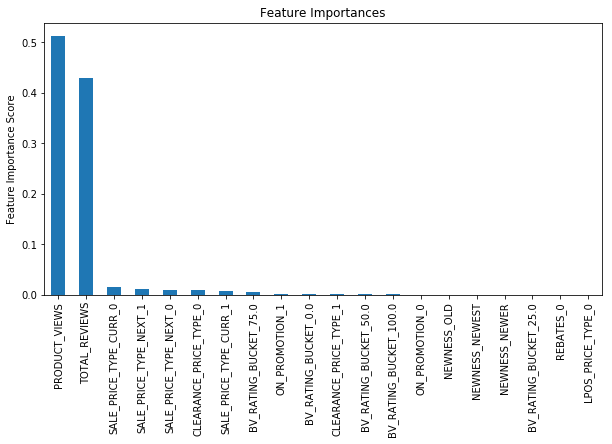

In [155]:
ID =['PRODUCT_ID']
target = ['SALES_NEXT_SEG_4']
# predictors = ['AVAILABLE_QTY_ON_HAND', 'BV_NUM_OF_REVIEWS','BV_RATING', 'CM_ADD_TO_BAG_CNV_PCT', 'CM_PRODUCT_CNV_PCT',
#        'CM_PRODUCT_VIEW', 'CS_AVAILABLE_QTY_ON_HAND', 'CS_ON_HAND_DOLLARS','GROSS_MARGIN', 'NUM_PRD_ADDED_TO_REGISTRY', 'ON_HAND_DOLLARS',
#        'PRODUCT_AGE', 'RETAIL_PRICE', 'SALES_DOLLARS','SALES_DOLLARS_1_DAY', 'SELL_THRU_PCT', 'UNIT_SALES',
#        'SALES_HIST_SEG_4', 
#        'SALES_CURR_SEG_4', 
#        'PRODUCT_VIEWS', 'TOTAL_REVIEWS', 'CLEARANCE_PRICE_TYPE_0', 'CLEARANCE_PRICE_TYPE_1', 'LPOS_PRICE_TYPE_0', 'REBATES_0',
#        'SALE_PRICE_TYPE_CURR_0', 'SALE_PRICE_TYPE_CURR_1','SALE_PRICE_TYPE_NEXT_0', 'SALE_PRICE_TYPE_NEXT_1', 'NEWNESS_NEWER',
#        'NEWNESS_NEWEST', 'NEWNESS_OLD', 'ON_PROMOTION_0', 'ON_PROMOTION_1', 'BV_RATING_BUCKET_0.0', 'BV_RATING_BUCKET_25.0',
#        'BV_RATING_BUCKET_50.0', 'BV_RATING_BUCKET_75.0', 'BV_RATING_BUCKET_100.0']

predictors = [  
       'PRODUCT_VIEWS', 'TOTAL_REVIEWS', 'CLEARANCE_PRICE_TYPE_0', 'CLEARANCE_PRICE_TYPE_1', 'LPOS_PRICE_TYPE_0', 'REBATES_0',
       'SALE_PRICE_TYPE_CURR_0', 'SALE_PRICE_TYPE_CURR_1','SALE_PRICE_TYPE_NEXT_0', 'SALE_PRICE_TYPE_NEXT_1', 'NEWNESS_NEWER',
       'NEWNESS_NEWEST', 'NEWNESS_OLD', 'ON_PROMOTION_0', 'ON_PROMOTION_1', 'BV_RATING_BUCKET_0.0', 'BV_RATING_BUCKET_25.0',
       'BV_RATING_BUCKET_50.0', 'BV_RATING_BUCKET_75.0', 'BV_RATING_BUCKET_100.0']

# predictors = ['SALES_HIST_SEG_4','SALES_CURR_SEG_4',
# 'TOTAL_REVIEWS','CLEARANCE_PRICE_TYPE_0','CLEARANCE_PRICE_TYPE_1','LPOS_PRICE_TYPE_0','REBATES_0','SALE_PRICE_TYPE_0',
# 'SALE_PRICE_TYPE_1','NEWNESS_NEWER','NEWNESS_NEWEST','NEWNESS_OLD','ON_PROMOTION_0','ON_PROMOTION_1',
# 'BV_RATING_BUCKET_0.0','BV_RATING_BUCKET_25.0','BV_RATING_BUCKET_50.0','BV_RATING_BUCKET_75.0','BV_RATING_BUCKET_100.0',
#               'PRODUCT_VIEWS']

#predictors = [x for x in data_train.columns if x not in [ID,target,ignore_vars]]
for tgt in target:
    
    gbm0 = GradientBoostingRegressor(random_state=100)
    clf = modelfit(gbm0, data_train, predictors,tgt,performCV=True,printFeatureImportance=True,cv_folds=5,
             save_model=False,modelFileName='model.sav')

    data_test['PREDICTED_GBM'] = clf.predict(data_test[predictors])
    print_test_results(data_test.SALES_NEXT_SEG_4, data_test['PREDICTED_GBM'])
    data_test.rename(columns={'PREDICTED_GBM':"PREDICTED_SEG" + str(tgt.split("_")[-1])},inplace=True)

In [156]:
data_test[['PRODUCT_ID','SALES_HIST_SEG_4','SALES_CURR_SEG_4','SALES_NEXT_SEG_4','PREDICTED_SEG4']].sort_values(by="SALES_NEXT_SEG_4",ascending=False)

,PRODUCT_ID,SALES_HIST_SEG_4,SALES_CURR_SEG_4,SALES_NEXT_SEG_4,PREDICTED_SEG4
10816,2693770,1611.0,358.00,358.00,158.736205
14712,3047259,0.0,0.00,268.00,164.776457
6662,1779541,267.0,89.00,267.00,312.719552
41113,5201871,125.0,0.00,250.00,20.938696
41132,5201912,537.9,107.58,215.16,33.603351
41122,5201895,0.0,0.00,179.00,55.706760
41099,5201847,0.0,0.00,179.00,11.959807
29005,4863877,179.0,0.00,179.00,1.753869
41090,5201825,1288.0,0.00,161.00,118.942654
40940,5197147,322.0,0.00,161.00,24.747294


In [162]:
user_data[(user_data['WEB_PROD_ID']==2693770) & (user_data['SEGMENT']==4)].sort_values(by="ORIG_ORD_DT")

,ORIG_ORD_DT,SRC_SYS_KEY,WEB_PROD_ID,SEGMENT,SALES,QTY,R_SCORE,F_SCORE,M_SCORE,RFM_SCORE,RFM_SEG
206712,2018-01-22,1362322109,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
435220,2018-01-22,6479208485,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
565124,2018-01-22,8994440905,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
561411,2018-01-23,8949811041,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
912404,2018-01-23,1406826446,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
269650,2018-01-24,2631580063,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
584485,2018-01-24,9222646132,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
744484,2018-01-25,6670592895,2693770,4.0,179.0,1,4.0,3.0,5.0,42.0,3.0
472107,2018-01-26,7017639090,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0
460240,2018-01-27,6797543478,2693770,4.0,179.0,1,5.0,5.0,5.0,50.0,1.0


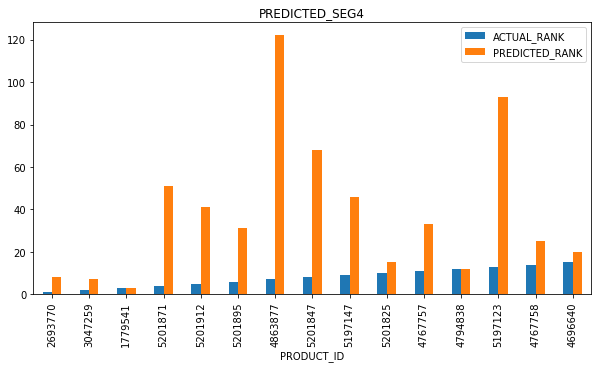

In [157]:
def rank_plot(data_test,pred_var):
    data_test.sort_values(by=pred_var,ascending=False,inplace=True)
    data_test['PREDICTED_RANK'] = range(1,len(data_test)+1)
    data_test.sort_values(by="SALES_NEXT_SEG_4",ascending=False,inplace=True)
    data_test['ACTUAL_RANK'] = range(1,len(data_test)+1)

    data = data_test[['PRODUCT_ID','ACTUAL_RANK','PREDICTED_RANK']].head(15)
    data.index = data['PRODUCT_ID']
    del data['PRODUCT_ID']
    data.plot(kind='bar',title=pred_var)

    
for pred_var in ['PREDICTED_SEG4']:
    rank_plot(data_test,pred_var)

In [50]:
# rdpp_data_28 = get_rdpp_dump("2018-01-28")
rdpp_data_29 = get_rdpp_dump("2018-01-29")
# rdpp_data_30 = get_rdpp_dump("2018-01-30")
# rdpp_data_31 = get_rdpp_dump("2018-01-31")
# rdpp_data_01 = get_rdpp_dump("2018-02-01")

In [51]:
print rdpp_data_28[rdpp_data_28['PRODUCT_ID']== 2232615]['SALE_PRICE_TYPE']
print rdpp_data_29[rdpp_data_29['PRODUCT_ID']== 2232615]['SALE_PRICE_TYPE']
print rdpp_data_30[rdpp_data_30['PRODUCT_ID']== 2232615]['SALE_PRICE_TYPE']
print rdpp_data_31[rdpp_data_31['PRODUCT_ID']== 2232615]['SALE_PRICE_TYPE']
print rdpp_data_01[rdpp_data_01['PRODUCT_ID']== 2232615]['SALE_PRICE_TYPE']

31236    0
Name: SALE_PRICE_TYPE, dtype: int64
31153    0
Name: SALE_PRICE_TYPE, dtype: int64
31172    1
Name: SALE_PRICE_TYPE, dtype: int64
30940    1
Name: SALE_PRICE_TYPE, dtype: int64
Series([], Name: SALE_PRICE_TYPE, dtype: int64)
